In [1]:
from datetime import datetime
from pathlib import Path
from typing import Optional
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.tsa.arima.model import ARIMA


# Sugarbowl Exploratory page
**Syracuse University IST736 Summer 2025 by La Monte Henry Piggy Yarroll and JJ Balasi**

## Introduction

## Data

In [2]:
!pwd

/home/piggy/src/github.com/piggyatbaqaqi/sugarbowl/explore


In [3]:
raw_data_path = Path('../data/La_Monte_Yarroll_glucose_7-20-2025.csv')
raw_data = pd.read_csv(raw_data_path, header=1)

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124907 entries, 0 to 124906
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Device                            124907 non-null  object 
 1   Serial Number                     124907 non-null  object 
 2   Device Timestamp                  124907 non-null  object 
 3   Record Type                       124907 non-null  int64  
 4   Historic Glucose mg/dL            106874 non-null  float64
 5   Scan Glucose mg/dL                12610 non-null   float64
 6   Non-numeric Rapid-Acting Insulin  0 non-null       float64
 7   Rapid-Acting Insulin (units)      0 non-null       float64
 8   Non-numeric Food                  0 non-null       float64
 9   Carbohydrates (grams)             50 non-null      float64
 10  Carbohydrates (servings)          0 non-null       float64
 11  Non-numeric Long-Acting Insulin   0 non-null       f

In [5]:
data = raw_data[['Record Type', 'Serial Number', 'Historic Glucose mg/dL', 'Scan Glucose mg/dL', 'Carbohydrates (grams)', 'Notes']].copy()

In [6]:
time_format = '%m-%d-%Y %H:%M %p'
data.loc[:, 'timestamp'] = raw_data['Device Timestamp'].map(lambda t: datetime.strptime(t, time_format))
data.sort_values(by='timestamp', ascending=True, inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124907 entries, 1 to 106819
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Record Type             124907 non-null  int64         
 1   Serial Number           124907 non-null  object        
 2   Historic Glucose mg/dL  106874 non-null  float64       
 3   Scan Glucose mg/dL      12610 non-null   float64       
 4   Carbohydrates (grams)   50 non-null      float64       
 5   Notes                   1874 non-null    object        
 6   timestamp               124907 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 7.6+ MB


In [8]:
def get_meals(data: pd.DataFrame) -> pd.DataFrame:
    retval = data[(data['Record Type'] == 6) & (data['Notes'] != '')
                  & (data['Notes'].isna().map(lambda x: not x))]
    return retval.reset_index(drop=True)
meals = get_meals(data)
print(f"Number of meals: {len(meals)}")

Number of meals: 1874


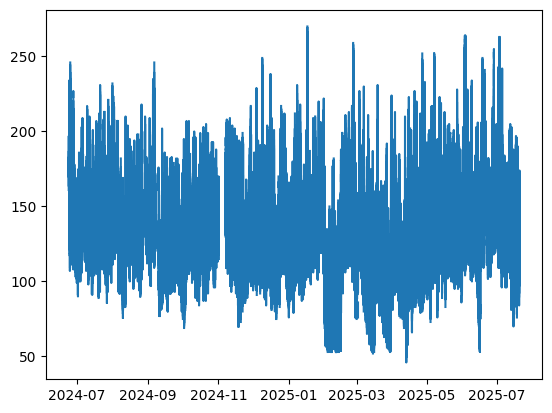

In [9]:
plt.plot(data['timestamp'], data['Historic Glucose mg/dL'])
plt.show()

In [10]:
data['Serial Number'].value_counts()

Serial Number
0e154b86-bf50-4004-9ddb-123beeb2e7c4    124900
22c6a4d9-071c-476f-b04b-3d6ea3761356         6
a67a800c-57e1-46c9-b156-804a3a3f702a         1
Name: count, dtype: int64

In [11]:
# Define potential glucose columns and keep only those that exist
glucose_columns = [col for col in ['Scan Glucose mg/dL', 'Historic Glucose mg/dL', 'Strip Glucose mg/dL'] if col in data.columns]

# Use backfill to combine available glucose readings
data['glucose'] = data[glucose_columns].bfill(axis=1).iloc[:, 0]

print(f"DEBUG: {data['glucose'].isna().sum()}")

DEBUG: 5423


In [23]:
DURATION = pd.Timedelta(hours=2)
MIN_RECORD_PCT = 0.90
DURATION_INCREMENT = pd.Timedelta(minutes=5)
MIN_DURATION_COUNT = int(MIN_RECORD_PCT * DURATION / DURATION_INCREMENT)
def glycemic_increment(data: pd.DataFrame, when: pd.Timestamp) -> Optional[np.float64]:
    '''Calculate the glycemic increment starting at when.
    
    We assume that data contains only records with valid glucose values.
    
    This version does not compensate for additional meals in the same interval.
    
    Returns mg*seconds/dL, or None if there is insufficient data.
    '''
    # Calculate the end.
    end = when + DURATION
    # Find the start.
    i = (data['timestamp'] >= when).idxmax()
    if data['timestamp'][i] < when:
        print(f"DEBUG: Ran off end looking for start: {when}")
        return None  # We ran off the end
    # Extract the region.
    j = (data['timestamp'] >= end).idxmax()
    if j == 0:
        print("DEBUG: Ran off end looking for end: {end}")
        return None  # We ran off the end.
    
    if (j - i) < MIN_DURATION_COUNT:
        # print(f"DEBUG: Not enough records: (j: {j} - i: {i}) = {j - i} < {MIN_DURATION_COUNT}")
        return None  # There aren't enough records
    
    total = 0
    prev = data.iloc[i]
    first = prev
    for c in range(i, j):
        current = data.iloc[c]
        total += ((current['timestamp'] - prev['timestamp']).total_seconds()
                  * (current['glucose'] - first['glucose']))
        prev = current

    return total
        

In [20]:
glucose_data = data.dropna(subset=['glucose']).copy().reset_index(drop=True)
glucose_data['glucose'] = pd.to_numeric(glucose_data['glucose'], errors='coerce')
glucose_data

,Record Type,Serial Number,Historic Glucose mg/dL,Scan Glucose mg/dL,Carbohydrates (grams),Notes,timestamp,glucose
0,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,180.0,NaN,NaN,NaN,2024-06-24 01:02:00,180.0
1,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,176.0,NaN,NaN,NaN,2024-06-24 01:07:00,176.0
2,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,180.0,NaN,NaN,NaN,2024-06-24 01:12:00,180.0
3,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,181.0,NaN,NaN,NaN,2024-06-24 01:17:00,181.0
4,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,173.0,NaN,NaN,NaN,2024-06-24 01:22:00,173.0
...,...,...,...,...,...,...,...,...
119479,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,133.0,NaN,NaN,NaN,2025-07-20 12:46:00,133.0
119480,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,133.0,NaN,NaN,NaN,2025-07-20 12:51:00,133.0
119481,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,103.0,NaN,NaN,NaN,2025-07-20 12:51:00,103.0
119482,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,104.0,NaN,NaN,NaN,2025-07-20 12:56:00,104.0


In [25]:
increments = meals.apply(lambda d: glycemic_increment(glucose_data, d['timestamp']), axis=1)   
# glycemic_increment(glucose_data, meals['timestamp'][10])
print(f"incomplete increments: {increments.isna().sum()}")
meals['increment'] = increments

incomplete increments: 143


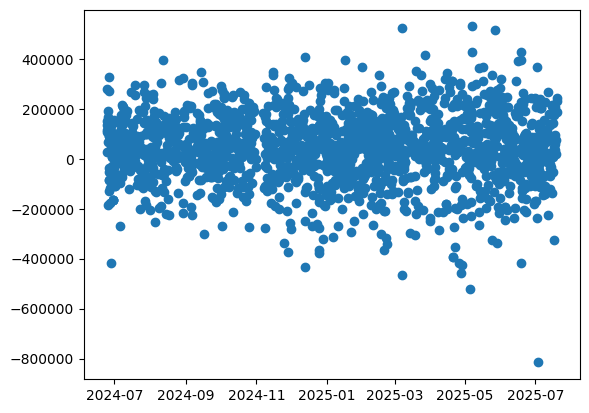

In [26]:
plt.scatter(meals['timestamp'], meals['increment'])

## Methods and Models

## Experimental Design and Investigation Strategy

## Results and Observations

## Conclusions

## Appendix

## Bibliography